# CSV Speed Comparison

This notebook will simply show the performance between using CSV and Parquet format.

First, prepare a huge data source in CSV format for testing. Here I used a public business registry data source from [here](https://info.gbiz.go.jp/hojin/DownloadTop). You can download any CSV on the site.

In [61]:
import numpy as np
import pandas as pd
import time
from sys import getsizeof
import csv
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr  

A dict to keep our testing results

In [2]:
benchmark = {
    "csv": {},
    "pq_gzip": {},
    "pq_no_compress": {}
}

----

## CSV format

Now let us read the CSV file into variable.


In [59]:
# Change to your file name
csv_f = "./tmp/Kihonjoho_UTF-8_20230410.csv"

tic = time.perf_counter()
csv_df = pd.read_csv(csv_f)
toc = time.perf_counter()
benchmark["csv"]["read_time"] = toc - tic
print(f"Loaded data in {toc - tic:0.4f} seconds")


Loaded data in 21.1172 seconds


And we can use `getsizeof` to check the variable size. 

If you open the Activity Monitor on MacOS, the *memory* column might show a lower number. You need to show another column *Real Memory* that make more sense.

In [9]:
csv_df_size = getsizeof(csv_df)
print(f"size of CSV df: {csv_df_size} bytes")
print(f"size of CSV df: {csv_df_size/(1024*1024):0.0f} MB")
benchmark["csv"]["memory"] = csv_df_size

size of CSV df: 4057110637 bytes
size of CSV df: 3869 MB


Also we test the CSV write speed here:

In [10]:
tmp_new_csv = "./tmp/tmp_large.csv"

tic = time.perf_counter()
# Depends on your original CSV, you might need to change below param to match the original CSV.
csv_df.to_csv(tmp_new_csv, index=False, quoting=csv.QUOTE_ALL)
toc = time.perf_counter()
benchmark["csv"]["write_time"] = toc - tic
print(f"Write data in {toc - tic:0.4f} seconds")


Write data in 21.5839 seconds


In [20]:
print(f'File Size: {os.stat(tmp_new_csv).st_size / (1024 * 1024):0.0f} MB')
benchmark["csv"]["file_size"] = os.stat(tmp_new_csv).st_size

File Size: 1092 MB


Let's have a quick look of the CSV testing result before moving on.

In [21]:
print(benchmark["csv"])

{'read_time': 19.494181496000238, 'memory': 4057110637, 'write_time': 21.583862373001466, 'file_size': 1144707784}


----

## Parquet format

We will convert the dataframe into [Parquet](https://parquet.apache.org/) format file.  Refer to user guide [here](https://pandas.pydata.org/docs/user_guide/io.html#io-parquet).

From the pandas [document](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_parquet.html), the method `to_parquet()` provides compression:
> compression{‘snappy’, ‘gzip’, ‘brotli’, None}, default ‘snappy’

We will try no compression and gzip.


In [26]:
# the extension is parquet for no compression
pq_f = "./tmp/csv_to_pq.parquet"
pq_gzip = "./tmp/csv_to_pq.gzip"

In [27]:
tic = time.perf_counter()
# No compression
csv_df.to_parquet(pq_f, compression=None)
toc = time.perf_counter()
benchmark["pq_no_compress"]["write_time"] = toc - tic
print(f"Write without compression in {toc - tic:0.4f} seconds")


tic = time.perf_counter()
# No compression
csv_df.to_parquet(pq_gzip, compression="gzip")
toc = time.perf_counter()
benchmark["pq_gzip"]["write_time"] = toc - tic
print(f"Write gzip file in {toc - tic:0.4f} seconds")


Write without compression in 3.8836 seconds
Write gzip file in 33.7980 seconds


In [30]:
# If the csv dataset is too large, we might run out of memory. You can optionally run this code block to release some memory.
csv_df = None

It is 2x quicker for no compression, while gzip compression took longer than CSV writing. What about the file size?

In [28]:
print(f'File Size of no compression parquet: {os.stat(pq_f).st_size / (1024 * 1024):0.0f} MB')
benchmark["pq_no_compress"]["file_size"] = os.stat(pq_f).st_size

print(f'File Size of gzip parquet: {os.stat(pq_gzip).st_size / (1024 * 1024):0.0f} MB')
benchmark["pq_gzip"]["file_size"] = os.stat(pq_gzip).st_size

File Size of no compression parquet: 622 MB
File Size of gzip parquet: 167 MB


The gzip size is much smaller. This could be a big benefit if working with the large data requires network transferring.

Also we need the reading time for record. We can read the parquet file like how we read CSV file:

In [32]:

tic = time.perf_counter()
pq_df = pd.read_parquet(pq_f)
toc = time.perf_counter()
benchmark["pq_no_compress"]["read_time"] = toc - tic
print(f"Read data in {toc - tic:0.4f} seconds")

## Gzip
tic = time.perf_counter()
pq_gzip_df = pd.read_parquet(pq_gzip)
toc = time.perf_counter()
benchmark["pq_gzip"]["read_time"] = toc - tic
print(f"Read gzip data in {toc - tic:0.4f} seconds")


Read data in 7.3965 seconds
Read gzip data in 7.9483 seconds


It is interesting that reading the parquet file with or without compression took almost the same time. And surprised that reading from gzip is faster than writing to it.

In [37]:
print("Non-compressed pq rows: ", len(pq_df))
print("gzip pq rows: ", len(pq_gzip_df))


pq_df_size = getsizeof(pq_df)
print(f"size of pq(no-compress) df: {pq_df_size/(1024*1024):0.0f} MB")
benchmark["pq_no_compress"]["memory"] = pq_df_size

# gzip
pq_gzip_df_size = getsizeof(pq_gzip_df)
print(f"size of gzip pq df: {pq_gzip_df_size/(1024*1024):0.0f} MB")
benchmark["pq_gzip"]["memory"] = pq_gzip_df_size

Non-compressed pq rows:  5296751
gzip pq rows:  5296751
size of pq(no-compress) df: 3455 MB
size of gzip pq df: 3455 MB


From the result above, the occupied memory does not decrease too much and that makes sense, because parquet is about how we STORE the file with compression and optimization.

------

## Result

At last, we will illustrate the benchmark from the result above.

In [39]:
from pprint import pprint as pp
# A quick look
pp(benchmark)

{'csv': {'file_size': 1144707784,
         'memory': 4057110637,
         'read_time': 19.494181496000238,
         'write_time': 21.583862373001466},
 'pq_gzip': {'file_size': 174742381,
             'memory': 3622776301,
             'read_time': 7.948349362002773,
             'write_time': 33.798009171998274},
 'pq_no_compress': {'file_size': 652689053,
                    'memory': 3622776301,
                    'read_time': 7.3964715270012675,
                    'write_time': 3.8835563019965775}}


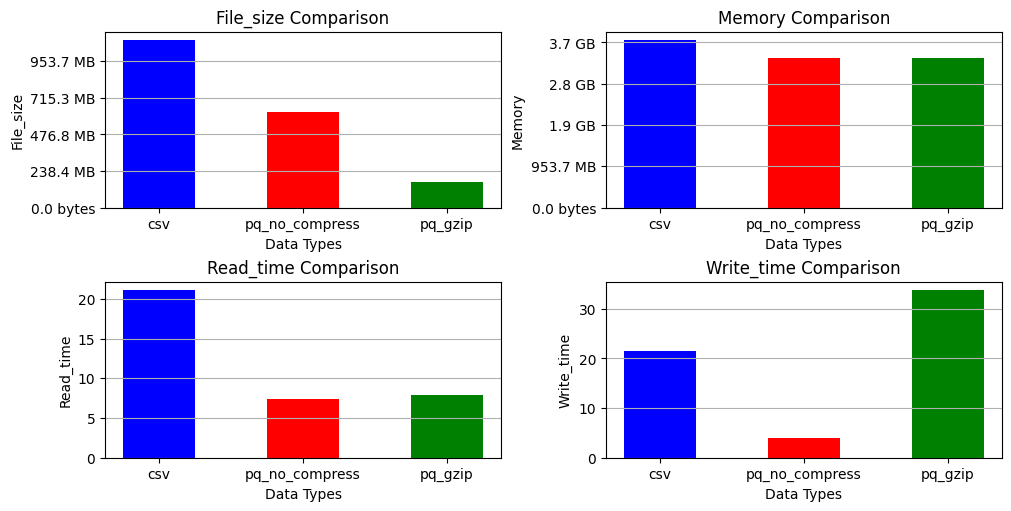

In [76]:
data = benchmark


# Extracting the required data
types = ['csv', 'pq_no_compress', 'pq_gzip']
fields = ['file_size', 'memory', 'read_time', 'write_time']
data_values = [[data[t][field] for t in types] for field in fields]
my_colors = ['b', 'r', 'g', 'y', 'k']

# scale for memory
def sizeof_fmt(x, pos):
    if x<0:
        return ""
    for x_unit in ['bytes', 'kB', 'MB', 'GB', 'TB']:
        if x < 1024.0:
            return "%3.1f %s" % (x, x_unit)
        x /= 1024.0

# Plotting subplots
plt.figure(figsize=(10,5), layout='constrained')
for i, field in enumerate(fields):
    ax = plt.subplot(221+i)
    plt.bar(types, data_values[i], color=my_colors, width=0.5)
    if field in ["memory", "file_size"]:
        ax.yaxis.set_major_formatter(tkr.FuncFormatter(sizeof_fmt))
    plt.xlabel('Data Types')
    plt.ylabel(field.capitalize())
    plt.title(f'{field.capitalize()} Comparison')
    plt.grid(axis='y')

plt.show()

From above result, we can see the significant benefit from using Parquet over CSV for such a large dataset will be:
- Smaller file size -> improve network tranfer speed
- Faster read/write time -> (Except the write time of gzip) I/O is a biggest concern when dealing dataset with such size.